In [86]:
import os
import pandas as pd
import numpy as np
from IPython.display import display
%matplotlib inline
training_file_path = os.path.expanduser('~/Documents/machine_learning_projects/predicting_backorders/Kaggle_Training_Dataset_v2.csv')
testing_file_path = os.path.expanduser('~/Documents/machine_learning_projects/predicting_backorders/Kaggle_Test_Dataset_v2.csv')
training_data = pd.read_csv(training_file_path)
testing_data = pd.read_csv(testing_file_path)
testing_data = testing_data.dropna()
training_data = training_data.dropna()

In [87]:
training_data = training_data.replace(['Yes','No'],[1,0])
testing_data = testing_data.replace(['Yes','No'],[1,0])

In [88]:
def columns_continuous_features_extract(data):
    columns = data.columns 
    results_dict = {}
    continuous_features = []
    column_index = 0
    continuous_features_index_tracker = []
    for column in columns:
            #print column
            type_value = type(data[column].values[0])
            if (type_value == np.float64):
                continuous_features.append(column)
                continuous_features_index_tracker.append(column_index)
            column_index += 1
    results_dict['columns'] = columns
    results_dict['continuous_features'] = continuous_features
    return results_dict

# print continuous_features
# print len(continuous_features)
# print continuous_features_index_tracker
# print len(continuous_features_index_tracker)
results = columns_continuous_features_extract(training_data)
print results['columns']
print results['continuous_features']

Index([u'sku', u'national_inv', u'lead_time', u'in_transit_qty',
       u'forecast_3_month', u'forecast_6_month', u'forecast_9_month',
       u'sales_1_month', u'sales_3_month', u'sales_6_month', u'sales_9_month',
       u'min_bank', u'potential_issue', u'pieces_past_due',
       u'perf_6_month_avg', u'perf_12_month_avg', u'local_bo_qty',
       u'deck_risk', u'oe_constraint', u'ppap_risk', u'stop_auto_buy',
       u'rev_stop', u'went_on_backorder'],
      dtype='object')
['national_inv', 'lead_time', 'in_transit_qty', 'forecast_3_month', 'forecast_6_month', 'forecast_9_month', 'sales_1_month', 'sales_3_month', 'sales_6_month', 'sales_9_month', 'min_bank', 'pieces_past_due', 'perf_6_month_avg', 'perf_12_month_avg', 'local_bo_qty']


In [107]:
def roc_plot(y_test, y_predict_proba, title = 'Default ROC Curve',clf_plot_color = 'darkorange', random_plot_color ='navy'):
    
    from sklearn.metrics import roc_curve, roc_auc_score 
    import matplotlib.pyplot as plt 

    auc_score = roc_auc_score(y_test, y_predict_proba[:,1])
    fpr, tpr, thresholds = roc_curve(y_test, y_predict_proba[:,1])
    plt.plot(fpr,tpr, color=clf_plot_color,lw=2, label = 'ROC-AUC Score = %0.2f' % auc_score)
    plt.plot([0, 1], [0, 1], color=random_plot_color, lw=2, linestyle='--', label = 'Completely Random Classifier')
    plt.xlabel("FPR%")
    plt.ylabel("TPR%")
    plt.legend(loc='lower right')
    plt.title(title)
    plt.show()
    #display(base_auc_score)
    results_dict = {'auc_score':auc_score, 'fpr':fpr, 'tpr':tpr,'thresholds':thresholds}
    return results_dict
    
    

In [110]:
def precision_recall_plot(y_test, y_predict_proba, title = 'Default Precision Recall Curve', clf_plot_color = 'red'):
    
    from sklearn.metrics import precision_recall_curve
    import matplotlib.pyplot as plt 

    precision, recall, threshold = precision_recall_curve(y_test, y_predict_proba[:,1])
    plt.plot(recall, precision, color = clf_plot_color, lw = 2)
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(title)
    plt.show()
    
    results_dict = {'precision':precision, 'recall':recall, 'threshold':threshold}
    return results_dict 

In [115]:
def calibration_plot(y_test, y_predict_proba, tit classifier_label = 'default classifier label', n_bins = 10, normalize = True, clf_plot_color = 'blue', ideal_plot_color = 'navy'):
    
    from sklearn.calibration import calibration_curve
    import matplotlib.pyplot as plt 

    frac_of_pos, mean_pred_val = calibration_curve(y_test, y_predict_proba[:,1], n_bins = n_bins, normalize = normalize)
    plt.plot(mean_pred_val, frac_of_pos, color = 'blue', lw = 2, label = classifier_label)
    plt.plot([0,1], [0,1], color = 'navy', lw =2, linestyle = '--', label = 'Perfectly Calibrated Classifer')
    plt.xlabel('Mean Predicted Value')
    plt.ylabel('Fraction of Positives')
    plt.title('Calibration Curve (With CV) For Normalized Data (Without PCA), SMOTED, Isotonically Calibrated RF Classifier')
    plt.legend(loc = 'lower right')
    plt.show()

## Data Visualization & Feature Space Reduction



In [90]:
#general description of continuous variables
#display(training_data.describe())
display(training_data.median())
#How can the median of some of the categories be 0.00 exactly? Perhaps the medi

sku                  1955693.00
national_inv              14.00
lead_time                  8.00
in_transit_qty             0.00
forecast_3_month           0.00
forecast_6_month           0.00
forecast_9_month           0.00
sales_1_month              0.00
sales_3_month              1.00
sales_6_month              3.00
sales_9_month              4.00
min_bank                   0.00
potential_issue            0.00
pieces_past_due            0.00
perf_6_month_avg           0.84
perf_12_month_avg          0.82
local_bo_qty               0.00
deck_risk                  0.00
oe_constraint              0.00
ppap_risk                  0.00
stop_auto_buy              1.00
rev_stop                   0.00
went_on_backorder          0.00
dtype: float64

In [91]:
display(training_data.describe())

,national_inv,lead_time,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,sales_9_month,...,pieces_past_due,perf_6_month_avg,perf_12_month_avg,local_bo_qty,deck_risk,oe_constraint,ppap_risk,stop_auto_buy,rev_stop,went_on_backorder
count,1.586967e+06,1.586967e+06,1.586967e+06,1.586967e+06,1.586967e+06,1.586967e+06,1.586967e+06,1.586967e+06,1.586967e+06,1.586967e+06,...,1.586967e+06,1.586967e+06,1.586967e+06,1.586967e+06,1.586967e+06,1.586967e+06,1.586967e+06,1.586967e+06,1.586967e+06,1.586967e+06
mean,4.895098e+02,7.872267e+00,4.547493e+01,1.887439e+02,3.653390e+02,5.362801e+02,5.691140e+01,1.784835e+02,3.522319e+02,5.441272e+02,...,2.172666e+00,-1.014934e+00,-5.532225e-01,6.333207e-01,2.032538e-01,1.543825e-04,1.188090e-01,9.753675e-01,2.583545e-04,6.911927e-03
std,3.046168e+04,7.056024e+00,1.309357e+03,5.182992e+03,1.009962e+04,1.482576e+04,1.854775e+03,4.971129e+03,9.679297e+03,1.514871e+04,...,2.434021e+02,1.327273e+01,1.144580e+01,3.343933e+01,4.024199e-01,1.242412e-02,3.235638e-01,1.550025e-01,1.607134e-02,8.285021e-02
min,-2.725600e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,-9.900000e+01,-9.900000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,4.000000e+00,4.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,6.900000e-01,6.900000e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00
50%,1.400000e+01,8.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,3.000000e+00,4.000000e+00,...,0.000000e+00,8.400000e-01,8.200000e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00
75%,7.800000e+01,9.000000e+00,0.000000e+00,5.000000e+00,1.500000e+01,2.500000e+01,5.000000e+00,1.600000e+01,3.300000e+01,5.000000e+01,...,0.000000e+00,9.700000e-01,9.600000e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00
max,1.233440e+07,5.200000e+01,4.894080e+05,1.427612e+06,2.461360e+06,3.777304e+06,7.417740e+05,1.105478e+06,2.146625e+06,3.205172e+06,...,1.464960e+05,1.000000e+00,1.000000e+00,1.253000e+04,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


Notice that the mean and median of each category differs quite drastically. This indicates a need for data normalization. 

In [92]:
from sklearn import tree 
from sklearn import metrics
from sklearn.metrics import precision_score, recall_score

In [93]:
from sklearn.preprocessing import normalize
samples = training_data.sample(100000,random_state = 36)
#qty_related = ['national_inv', 'in_transit_qty', 'forecast_3_month', 
                   #'forecast_6_month', 'forecast_9_month', 'min_bank',
                   #'local_bo_qty', 'pieces_past_due', 'sales_1_month', 
                   #'sales_3_month', 'sales_6_month', 'sales_9_month',]
samples[continuous_features] = normalize(samples[continuous_features], axis=1)
testing_data[continuous_features] = normalize(testing_data[continuous_features], axis =1)

In [94]:
X_train_temp = samples.drop('went_on_backorder',axis = 1).values 
y_train_temp = samples['went_on_backorder'].values
X_test_temp = testing_data.drop('went_on_backorder', axis = 1).values
y_test_temp = testing_data['went_on_backorder'].values
print(X_train_temp.shape)
print(y_train_temp.shape)
display(X_train_temp)

(100000, 22)
(100000,)


array([[1388552, 0.712415101758609, 0.020354717193103115, ..., 1, 1, 0],
       [1903658, 0.16372731303383, 0.98236387820298, ..., 0, 1, 0],
       [2935990, 0.06986131844556695, 0.0015877572373992489, ..., 0, 1, 0],
       ..., 
       [2092506, 0.9993788211374025, 0.026299442661510592, ..., 1, 1, 0],
       [2105378, 0.282909958733525, 0.37721327831136664, ..., 0, 1, 0],
       [3041509, 0.16376013050862248, 0.982560783051735, ..., 0, 1, 0]], dtype=object)

In [95]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state = 12, ratio = 1.0)
x_smote_training_data, y_smote_training_data = sm.fit_sample(X_train_temp, y_train_temp)
print(np.bincount(y_smote_training_data))
#display(x_smote_df)

[99293 99293]


In [96]:
#majority classifier (baseline #1)
from sklearn.dummy import DummyClassifier
clf_dummy = DummyClassifier(strategy='most_frequent', random_state =0)
clf_dummy.fit(x_smote_training_data, y_smote_training_data)
clf_dummy_predictions = clf_dummy.predict(X_test_temp)
#accuracy score
print(clf_dummy.score(X_test_temp, y_test_temp))
#recall score
clf_dummy_recall = recall_score(y_test_temp,clf_dummy_predictions)
print clf_dummy_recall
#precision score 
clf_dummy_precision = precision_score(y_test_temp, clf_dummy_predictions)
print clf_dummy_precision

0.988546344639
0.0
0.0


0.843701996928
0.0306933597843


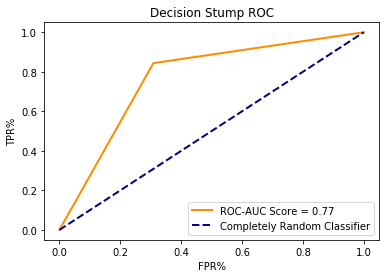

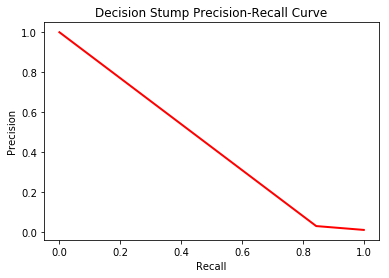

TypeError: calibration_plot() got an unexpected keyword argument 'title'

In [117]:
#baseline #2 classifier decision tree stump
from sklearn import tree
clf_stump = tree.DecisionTreeClassifier(max_depth=1)
clf_stump.fit(x_smote_training_data, y_smote_training_data)
clf_stump_predictions = clf_stump.predict(X_test_temp)
clf_stump_predictions_proba = clf_stump.predict_proba(X_test_temp)
print(recall_score(y_test_temp,clf_stump_predictions))
print(precision_score(y_test_temp, clf_stump_predictions))
roc_plot(y_test_temp,clf_stump_predictions_proba, title = "Decision Stump ROC")
precision_recall_plot(y_test_temp, clf_stump_predictions_proba, title = 'Decision Stump Precision-Recall Curve')
calibration_plot(y_test_temp, clf_stump_predictions_proba, title = 'Un-Calibrated Decision Stump Calibration Curve')

In [ ]:
#Without any preprocessing, normalization, just using the out-of-the-box Random Forest Classifier
#strange thing is that as the number of trees grow, the model's F1 score gets lower and lower
#keep in mind that F1 score is affected by class imbalance, refer to paper
from sklearn.ensemble import RandomForestClassifier
clf_temp = RandomForestClassifier(n_estimators=100, max_depth = 15)
#clf_temp = clf_temp.fit(X_train_temp, y_train_temp)
clf_temp = clf_temp.fit(x_smote_training_data, y_smote_training_data)
y_predict_temp = clf_temp.predict(X_test_temp)
score_temp = metrics.f1_score(y_test_temp, y_predict_temp)
y_predict_temp_proba = clf_temp.predict_proba(X_test_temp)
print score_temp


In [ ]:
clf_temp_precision_score = precision_score(y_test_temp, y_predict_temp)
clf_temp_recall_score = recall_score(y_test_temp, y_predict_temp)
print clf_temp_recall_score
print clf_temp_precision_score

In [ ]:
import matplotlib.pyplot as plt 
#taking a look at confusion matrix for the base Random Forest Classifier without class balancing
from sklearn.metrics import confusion_matrix 
import pandas as pd
import seaborn as sn
cm = confusion_matrix(y_test_temp, y_predict_temp)
display(cm)
sn.heatmap(cm)

In [ ]:
from sklearn.calibration import calibration_curve
frac_of_pos, mean_pred_val = calibration_curve(y_test_temp, y_predict_temp_proba[:,1], n_bins = 10, normalize = True)
plt.plot(mean_pred_val, frac_of_pos, color = 'blue', lw = 2, label = 'Unalibrated/Normalized/No-PCA/SMOTED RF')
plt.plot([0,1], [0,1], color = 'navy', lw =2, linestyle = '--', label = 'Perfectly Calibrated Classifer')
plt.xlabel('Mean Predicted Value')
plt.ylabel('Fraction of Positives')
plt.title('Calibration Curve (With CV) For Normalized Data (Without PCA), SMOTED, Uncalibrated RF Classifier')
plt.legend(loc = 'lower right')
plt.show()

In [ ]:
#time to do ROC curve analysis 
from sklearn.metrics import roc_curve, roc_auc_score 
base_auc_score = roc_auc_score(y_test_temp, y_predict_temp_proba[:,1])
fpr, tpr, thresholds = roc_curve(y_test_temp, y_predict_temp_proba[:,1])
plt.plot(fpr,tpr, color='darkorange',lw=2, label = 'ROC-AUC Score = %0.2f' % base_auc_score)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label = 'Completely Random Classifier')
plt.xlabel("FPR%")
plt.ylabel("TPR%")
plt.legend(loc='lower right')
plt.title("ROC (Without Cross-Validation) For Normalized Data (Without PCA) Without Over-Sampling or Under-Sampling, Uncalibrated Classifier")
plt.show()
display(base_auc_score)

In [ ]:
#calculating the precision recall curve 
from sklearn.metrics import precision_recall_curve
precision, recall, threshold = precision_recall_curve(y_test_temp, y_predict_temp_proba[:,1])
plt.plot(recall, precision, color = 'red', lw = 2)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision Recall Curve for Out of the Box Random Forest Classifier for Un-PCA-Reduced & Normalized Data")
plt.show()
#from what I can tell the out of the box classifier looks like shit

In [ ]:
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.cross_validation import KFold
kfold = KFold(len(X_train_temp),n_folds = 10)
calibrated_clf_temp = CalibratedClassifierCV(clf_temp, cv = kfold, method = 'isotonic')
calibrated_clf_temp = calibrated_clf_temp.fit(x_smote_training_data, y_smote_training_data)
y_predict_calibrated = calibrated_clf_temp.predict(X_test_temp)
score_calibrated = metrics.f1_score(y_test_temp,y_predict_calibrated)
y_predict_calibrated_proba = calibrated_clf_temp.predict_proba(X_test_temp)

In [ ]:
calibrated_clf_precision_score = precision_score(y_test_temp, y_predict_calibrated)
calibrated_clf_recall_score = recall_score(y_test_temp, y_predict_calibrated)
print calibrated_clf_precision_score
print calibrated_clf_recall_score
print y_predict_calibrated.shape
print y_smote_training_data.shape
print x_smote_training_data.shape
print sum(y_smote_training_data)

In [ ]:
print(sum(y_predict_calibrated))
print(y_predict_calibrated_proba)

In [ ]:
frac_of_pos, mean_pred_val = calibration_curve(y_test_temp, y_predict_calibrated_proba[:,1], n_bins = 10, normalize = True)
plt.plot(mean_pred_val, frac_of_pos, color = 'blue', lw = 2, label = 'Calibrated/Normalized/No-PCA/SMOTED RF')
plt.plot([0,1], [0,1], color = 'navy', lw =2, linestyle = '--', label = 'Perfectly Calibrated Classifer')
plt.xlabel('Mean Predicted Value')
plt.ylabel('Fraction of Positives')
plt.title('Calibration Curve (With CV) For Normalized Data (Without PCA), SMOTED, Isotonically Calibrated RF Classifier')
plt.legend(loc = 'lower right')
plt.show()

In [ ]:
#time to do ROC curve analysis for Calibrated/KFold-Validated, SMOTED, UNPCAed classifer still using Random Forest Algorithm 
calibrated_base_auc_score = roc_auc_score(y_test_temp, y_predict_calibrated_proba[:,1])
fpr, tpr, thresholds = roc_curve(y_test_temp, y_predict_calibrated_proba[:,1])
plt.plot(fpr,tpr, color='darkorange',lw=2, label = 'ROC-AUC Score = %0.2f' % calibrated_base_auc_score)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label = 'Completely Random Classifier')
plt.xlabel("FPR%")
plt.ylabel("TPR%")
plt.legend(loc='lower right')
plt.title("ROC(With CV) For Normalized Data (Without PCA), SMOTED, Isotonically Calibrated Classifier")
plt.show()
#display(base_auc_score)

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
y_train_sample = samples['went_on_backorder'].values
PCA_train = PCA(n_components=5)
#X_train_reduced = PCA_train.fit_transform(X_train_temp)
X_train_reduced = PCA_train.fit_transform(x_smote_training_data)
clf_PCA_only = RandomForestClassifier(n_estimators=100)
#clf_PCA_only = clf_PCA_only.fit(X_train_reduced, y_train_sample)
clf_PCA_only = clf_PCA_only.fit(X_train_reduced, y_smote_training_data)
X_dataset_test = testing_data.drop('went_on_backorder', axis=1).values
y_dataset_test = testing_data['went_on_backorder'].values
X_dataset_test_reduced = PCA_train.fit_transform(X_dataset_test)
y_dataset_test_predictions = clf_PCA_only.predict_proba(X_dataset_test_reduced)
#test_score = metrics.f1_score(y_dataset_test, y_dataset_test_predictions)
#print test_score 

In [ ]:
display(x_smote_training_data)

In [ ]:
#time to do ROC curve analysis 
from sklearn.metrics import roc_curve, roc_auc_score 
base_auc_score = roc_auc_score(y_dataset_test, y_dataset_test_predictions[:,1])
fpr, tpr, thresholds = roc_curve(y_dataset_test, y_dataset_test_predictions[:,1])
plt.plot(fpr,tpr, color='darkorange',lw=2, label = 'ROC-AUC Score = %0.2f' % base_auc_score)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label = 'Completely Random Classifier')
plt.xlabel("FPR%")
plt.ylabel("TPR%")
plt.legend(loc='lower right')
plt.title("ROC (Without Cross-Validation) For Normalized Data (Without PCA) Without Over-Sampling or Under-Sampling, Uncalibrated Classifier")
plt.show()
display(base_auc_score)

In [2]:
#calculating the precision recall curve 
from sklearn.metrics import precision_recall_curve
precision, recall, threshold = precision_recall_curve(y_dataset_test, y_dataset_test_predictions[:,1])
plt.plot(recall, precision, color = 'red', lw = 2)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision Recall Curve for Out of the Box Random Forest Classifier for Un-PCA-Reduced & Normalized Data")
plt.show()

#from what I can tell the out of the box classifier looks like shit

NameError: name 'y_dataset_test' is not defined

In [5]:
import numpy as np
from sklearn.base import BaseEstimator, ClassifierMixin,TransformerMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import euclidean_distances
from sklearn.utils.estimator_checks import check_estimator
from sklearn.decomposition import PCA


x = [0,1]
y = [0]
class custom_PCA1(BaseEstimator,ClassifierMixin):
    
    def __init__(self, demo_param='demo'):
        self.demo_param = demo_param

    def fit(self, X, y):

        # Check that X and y have correct shape
        X, y = check_X_y(X, y)
        # Store the classes seen during fit
        self.classes_ = unique_labels(y)

        self.X_ = X
        self.y_ = y
        # Return the classifier
        return self

    def predict(self, X):

        # Check is fit had been called
        check_is_fitted(self, ['X_', 'y_'])

        # Input validation
        X = check_array(X)

        closest = np.argmin(euclidean_distances(X, self.X_), axis=1)
        return self.y_[closest]
#custom_pca = custom_PCA1()
#custom_dot = custom_pca.fit(X_train_temp,y_train_temp)
#print custom_dot
print(check_estimator(custom_PCA1))




None


In [8]:
class custom_PCA(BaseEstimator,TransformerMixin):
    import pandas as pd 
    
    def __init__(self,n_components = None,continuous_features = None,all_features = None):
        self.n_components = n_components
        self.continuous_features = continuous_features
        self.all_features = all_features
        self.pca = PCA(n_components = self.n_components)        
        
    
    def continuous_feature_extract(self, X_original):
        X_dict = {}
        continuous_features = self.continuous_features
        all_features = self.all_features 
        X_original = pd.DataFrame(X_original, columns = all_features[0:(len(all_features)-1)])
        X_cont_only = X_original[continuous_features]
        X_non_cont = X_original.drop(continuous_features, axis =1)
        X_dict['X_non_cont'] = X_non_cont
        X_dict['X_cont_only'] = X_cont_only
        return X_dict
        
    
    def fit(self,X_original, y = None):
        X_dict = self.continuous_feature_extract(X_original)
        X_cont_only = X_dict['X_cont_only']
        X_non_cont = X_dict['X_non_cont']
        X_cont_only = pd.DataFrame(self.pca.fit(X_cont_only))
        X_joined =X_cont_only.join(X_non_cont)
        return X_joined
        

    def fit_transform(self,X_original, y = None):
        X_dict = self.continuous_feature_extract(X_original)
        X_cont_only = X_dict['X_cont_only']
        X_non_cont = X_dict['X_non_cont']
        X_cont_only = pd.DataFrame(self.pca.fit_transform(X_cont_only))
        X_joined = X_cont_only.join(X_non_cont)
        return X_joined
    
    def transform(self,X_original, y = None):
        X_dict = self.continuous_feature_extract(X_original)
        X_cont_only = X_dict['X_cont_only']
        X_non_cont = X_dict['X_non_cont']
        X_cont_only = pd.DataFrame(self.pca.transform(X_cont_only))
        X_joined = X_cont_only.join(X_non_cont)
        return X_joined

print(check_estimator(custom_PCA))

NameError: global name 'pd' is not defined

In [18]:
class DenseTransformer(BaseEstimator,TransformerMixin):

    def transform(self, X, y=None, **kwargs):
        return X

    def fit_transform(self, X, y=None, **kwargs):
        
        self.fit(X, y)
        return self.transform(X)

    def fit(self, X, y=None, **kwargs):
        return self


In [23]:
class JamesTransformer(BaseEstimator, TransformerMixin):
    
    from sklearn.decomposition import PCA
    
    def __init__(self,n_components = None, **kwargs):
        self.n_components = n_components
        self.pca = PCA(self.n_components)
    
    def transform(self, X, y=None, **kwargs):
        X = self.pca.transform(X)
        return X
    
    def fit_transform(self, X, y= None, **kwargs):
        X = self.pca.fit_transform(X)
        return X
    
    def fit(self, X, y=None, **kwargs):
        X = self.pca.fit(X)
        return X

In [70]:
from sklearn.decomposition import PCA
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.estimator_checks import check_estimator
from sklearn.datasets import load_digits

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV,StratifiedKFold

#pipeline test
pipe = Pipeline([('reduce_dim', JamesTransformer()),('classify', RandomForestClassifier())])
C_OPTIONS = [10,100]
N_COMPONENTS = [14]
param_grid = [{'classify__n_estimators': C_OPTIONS},
              {'reduce_dim__n_components':N_COMPONENTS}
             ]
#scoring = {'f1_score':'f1_micro', 'roc_auc_score':'roc_auc'}
#scoring = {'roc_auc_score':'roc_auc'}
grid = GridSearchCV(pipe, cv=StratifiedKFold(n_splits=10), n_jobs=1, param_grid=param_grid,scoring = 'roc_auc')
#digits = load_digits()
grid.fit(x_smote_training_data, y_smote_training_data)
#print grid
grid.predict(X_test_temp)
bestie = grid.best_estimator_
#print(grid.cv_results_)

In [72]:
#print bestie
#print grid.best_score_
temp_predict_proba = grid.predict_proba(X_test_temp)

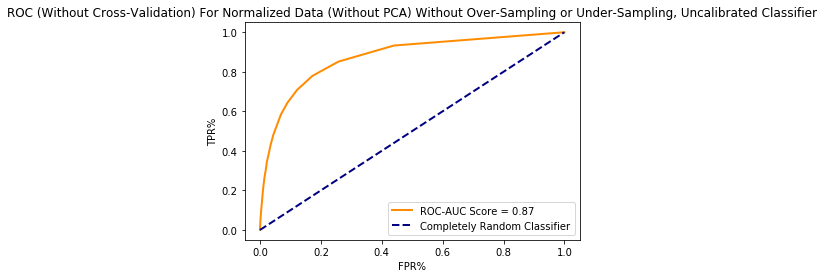

0.87233636484929011

In [74]:
#time to do ROC curve analysis 
from sklearn.metrics import roc_curve, roc_auc_score 
import matplotlib.pyplot as plt 
base_auc_score = roc_auc_score(y_test_temp, temp_predict_proba[:,1])
fpr, tpr, thresholds = roc_curve(y_test_temp, temp_predict_proba[:,1])
plt.plot(fpr,tpr, color='darkorange',lw=2, label = 'ROC-AUC Score = %0.2f' % base_auc_score)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label = 'Completely Random Classifier')
plt.xlabel("FPR%")
plt.ylabel("TPR%")
plt.legend(loc='lower right')
plt.title("ROC (Without Cross-Validation) For Normalized Data (Without PCA) Without Over-Sampling or Under-Sampling, Uncalibrated Classifier")
plt.show()
display(base_auc_score)

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

# pipe = Pipeline([
#     ('reduce_dim', PCA()),
#     ('classify', 
# ])

# N_FEATURES_OPTIONS = [2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,]
# C_OPTIONS = [1, 10, 100, 1000]
# param_grid = [
#     {
#         'reduce_dim': [PCA(iterated_power=7), NMF()],
#         'reduce_dim_n__components': N_FEATURES_OPTIONS,
#         'classify__C': C_OPTIONS
#     },
#     {
#         'reduce_dim': [SelectKBest(chi2)],
#         'reduce_dim__k': N_FEATURES_OPTIONS,
#         'classify__C': C_OPTIONS
#     },
# ]
# reducer_labels = ['PCA', 'NMF', 'KBest(chi2)']

# grid = GridSearchCV(pipe, cv=3, n_jobs=1, param_grid=param_grid)
# digits = load_digits()
# grid.fit(digits.data, digits.target)

x_pca_smote_train = custom_pca(x_smote_training_data,2, continuous_features)                        
#display(x_pca_smote_train)
x_pca_smote_test = custom_pca(X_test_temp,2,continuous_features)
print(x_pca_smote_train.shape)
print(x_pca_smote_test.shape)
#display(x_pca_smote_test)
clf_PCA_only_ = RandomForestClassifier(n_estimators=100)
clf_PCA_only = clf_PCA_only.fit(x_pca_smote_train, y_smote_training_data)
y_dataset_test_predictions = clf_PCA_only.predict(x_pca_smote_test)
y_dataset_test_predictions_proba = clf_PCA_only.predict_proba(x_pca_smote_test)
test_score = metrics.f1_score(y_dataset_test, y_dataset_test_predictions)

In [ ]:
#time to do ROC curve analysis 
from sklearn.metrics import roc_curve, roc_auc_score 
base_auc_score = roc_auc_score(y_dataset_test, y_dataset_test_predictions_proba[:,1])
fpr, tpr, thresholds = roc_curve(y_dataset_test, y_dataset_test_predictions_proba[:,1])
plt.plot(fpr,tpr, color='darkorange',lw=2, label = 'ROC-AUC Score = %0.2f' % base_auc_score)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label = 'Completely Random Classifier')
plt.xlabel("FPR%")
plt.ylabel("TPR%")
plt.legend(loc='lower right')
plt.title("ROC (Without Cross-Validation) For Normalized Data (Without PCA) Without Over-Sampling or Under-Sampling, Uncalibrated Classifier")
plt.show()
display(base_auc_score)